## Gradient Accumulation ON - FP32

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import os

In [3]:
gpu_device = 1
defaults.device = torch.device(f'cuda:{gpu_device}')
torch.cuda.set_device(gpu_device)

In [4]:
BS = 8
N_STEP = 4  # grad accumulation for n steps

In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/home/haider/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/models'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/leonberger_84.jpg'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_78.jpg'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/newfoundland_13.jpg'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/english_setter_63.jpg'),
 PosixPath('/home/haider/.fastai/data/oxford-iiit-pet/images/Persian_38.jpg')]

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [12]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):          pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr:Floats, wd:Floats=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
        
@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step
 
    def on_train_begin(self, **kwargs):
        "check if loss is reduction"
        if self.loss_func.reduction == "mean":
             print("For better gradients consider 'reduction=sum'")
        
    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_samples = 0
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_samples += last_input.shape[0]
        self.acc_batches += 1
        print(f"At batch {self.acc_batches}")
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_samples)
    
            print(f"Stepping at batch: {self.acc_batches}")
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_samples = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        self.learn.opt.real_step()
        self.learn.opt.real_zero_grad()

In [13]:
original_create_opt = Learner.create_opt
def turn_off_accumulation(): Learner.create_opt = original_create_opt
def turn_on_accumulation(): Learner.create_opt = acc_create_opt

In [14]:
seed_everything(2)

In [15]:
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [16]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=BS
                                  ).normalize(imagenet_stats)

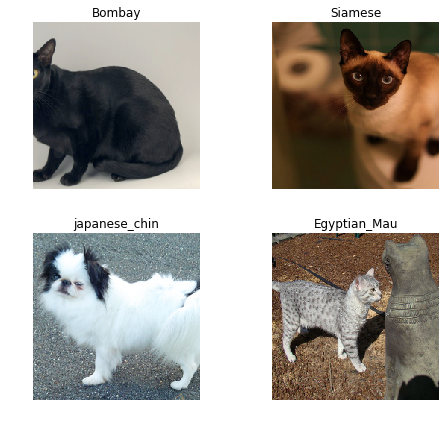

In [17]:
data.show_batch(rows=2, figsize=(7,6))

## Training: resnet34

In [18]:
def get_learner():
    turn_on_accumulation()
    learn = create_cnn(data=data, arch=models.resnet34, metrics=error_rate,
                       callback_fns=[partial(AccumulateStep, n_step=N_STEP)])
    learn.loss_func = CrossEntropyFlat(reduction="sum")
    return learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


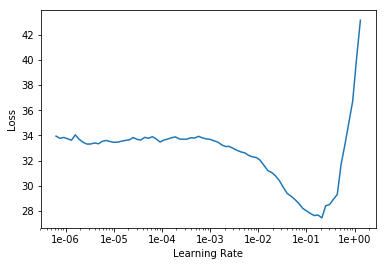

In [17]:
learn = get_learner() 
learn.lr_find() # pick lr
learn.recorder.plot()
learn = get_learner() 

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,7.560336,3.016698,0.123139
2,6.413884,2.253252,0.087957
3,4.214261,2.004601,0.082544
4,4.270155,1.902275,0.077131


At batch 1
At batch 2
At batch 3
At batch 4
Stepping at batch: 4
At batch 5
At batch 6
At batch 7
At batch 8
Stepping at batch: 8
At batch 9
At batch 10
At batch 11
At batch 12
Stepping at batch: 12
At batch 13
At batch 14
At batch 15
At batch 16
Stepping at batch: 16
At batch 17
At batch 18
At batch 19
At batch 20
Stepping at batch: 20
At batch 21
At batch 22
At batch 23
At batch 24
Stepping at batch: 24
At batch 25
At batch 26
At batch 27
At batch 28
Stepping at batch: 28
At batch 29
At batch 30
At batch 31
At batch 32
Stepping at batch: 32
At batch 33
At batch 34
At batch 35
At batch 36
Stepping at batch: 36
At batch 37
At batch 38
At batch 39
At batch 40
Stepping at batch: 40
At batch 41
At batch 42
At batch 43
At batch 44
Stepping at batch: 44
At batch 45
At batch 46
At batch 47
At batch 48
Stepping at batch: 48
At batch 49
At batch 50
At batch 51
At batch 52
Stepping at batch: 52
At batch 53
At batch 54
At batch 55
At batch 56
Stepping at batch: 56
At batch 57
At batch 58
At batc

### Unfreezing, fine-tuning, and learning rates

In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,4.245846,1.795542,0.075101
2,3.511938,1.740380,0.071719


At batch 1
At batch 2
At batch 3
At batch 4
Stepping at batch: 4
At batch 5
At batch 6
At batch 7
At batch 8
Stepping at batch: 8
At batch 9
At batch 10
At batch 11
At batch 12
Stepping at batch: 12
At batch 13
At batch 14
At batch 15
At batch 16
Stepping at batch: 16
At batch 17
At batch 18
At batch 19
At batch 20
Stepping at batch: 20
At batch 21
At batch 22
At batch 23
At batch 24
Stepping at batch: 24
At batch 25
At batch 26
At batch 27
At batch 28
Stepping at batch: 28
At batch 29
At batch 30
At batch 31
At batch 32
Stepping at batch: 32
At batch 33
At batch 34
At batch 35
At batch 36
Stepping at batch: 36
At batch 37
At batch 38
At batch 39
At batch 40
Stepping at batch: 40
At batch 41
At batch 42
At batch 43
At batch 44
Stepping at batch: 44
At batch 45
At batch 46
At batch 47
At batch 48
Stepping at batch: 48
At batch 49
At batch 50
At batch 51
At batch 52
Stepping at batch: 52
At batch 53
At batch 54
At batch 55
At batch 56
Stepping at batch: 56
At batch 57
At batch 58
At batc

# Training: resnet50

In [21]:
seed_everything(2)

In [22]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=BS).normalize(imagenet_stats)

In [23]:
def get_learner():
    turn_on_accumulation()
    learn = create_cnn(data=data, arch=models.resnet50, metrics=error_rate,
                       callback_fns=[partial(AccumulateStep, n_step=N_STEP)])
    learn.loss_func = CrossEntropyFlat(reduction="sum")
    return learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


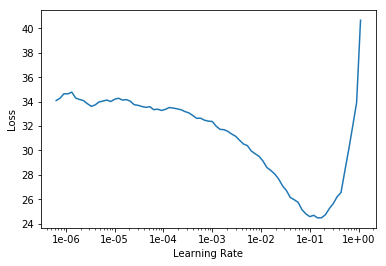

In [24]:
learn = get_learner() 
learn.lr_find() # pick lr
learn.recorder.plot()
learn = get_learner() 

In [25]:
learn.fit_one_cycle(5) 

epoch,train_loss,valid_loss,error_rate
1,5.619759,2.547731,0.091340
2,4.618773,1.901571,0.075778
3,4.532964,1.623351,0.064276
4,3.228310,1.549852,0.064953
5,2.385542,1.553665,0.062246


At batch 1
At batch 2
At batch 3
At batch 4
Stepping at batch: 4
At batch 5
At batch 6
At batch 7
At batch 8
Stepping at batch: 8
At batch 9
At batch 10
At batch 11
At batch 12
Stepping at batch: 12
At batch 13
At batch 14
At batch 15
At batch 16
Stepping at batch: 16
At batch 17
At batch 18
At batch 19
At batch 20
Stepping at batch: 20
At batch 21
At batch 22
At batch 23
At batch 24
Stepping at batch: 24
At batch 25
At batch 26
At batch 27
At batch 28
Stepping at batch: 28
At batch 29
At batch 30
At batch 31
At batch 32
Stepping at batch: 32
At batch 33
At batch 34
At batch 35
At batch 36
Stepping at batch: 36
At batch 37
At batch 38
At batch 39
At batch 40
Stepping at batch: 40
At batch 41
At batch 42
At batch 43
At batch 44
Stepping at batch: 44
At batch 45
At batch 46
At batch 47
At batch 48
Stepping at batch: 48
At batch 49
At batch 50
At batch 51
At batch 52
Stepping at batch: 52
At batch 53
At batch 54
At batch 55
At batch 56
Stepping at batch: 56
At batch 57
At batch 58
At batc

### Unfreeze

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,2.548705,1.469140,0.055480
2,2.679464,1.380971,0.057510
3,2.452512,1.386664,0.054127


At batch 1
At batch 2
At batch 3
At batch 4
Stepping at batch: 4
At batch 5
At batch 6
At batch 7
At batch 8
Stepping at batch: 8
At batch 9
At batch 10
At batch 11
At batch 12
Stepping at batch: 12
At batch 13
At batch 14
At batch 15
At batch 16
Stepping at batch: 16
At batch 17
At batch 18
At batch 19
At batch 20
Stepping at batch: 20
At batch 21
At batch 22
At batch 23
At batch 24
Stepping at batch: 24
At batch 25
At batch 26
At batch 27
At batch 28
Stepping at batch: 28
At batch 29
At batch 30
At batch 31
At batch 32
Stepping at batch: 32
At batch 33
At batch 34
At batch 35
At batch 36
Stepping at batch: 36
At batch 37
At batch 38
At batch 39
At batch 40
Stepping at batch: 40
At batch 41
At batch 42
At batch 43
At batch 44
Stepping at batch: 44
At batch 45
At batch 46
At batch 47
At batch 48
Stepping at batch: 48
At batch 49
At batch 50
At batch 51
At batch 52
Stepping at batch: 52
At batch 53
At batch 54
At batch 55
At batch 56
Stepping at batch: 56
At batch 57
At batch 58
At batc